In [4]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(2)(x)  # 2D bottleneck

# Decoder
x = layers.Dense(8*8*64, activation='relu')(encoded)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

# Models
autoencoder = models.Model(input_img, decoded)
encoder = models.Model(input_img, encoded)

# Compile & Train
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0504 - val_loss: 0.0375
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0375 - val_loss: 0.0372
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0370 - val_loss: 0.0370
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0370 - val_loss: 0.0370
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0368 - val_loss: 0.0369
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0368 - val_loss: 0.0367
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0368 - val_loss: 0.0367
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0368 - val_loss: 0.0367
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0367 - val_loss: 0.0367
Epoch 12/20
196/196 ━━━━━━━━━━━━━━━━━━━━

# Visualize 2D Encoded Features

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


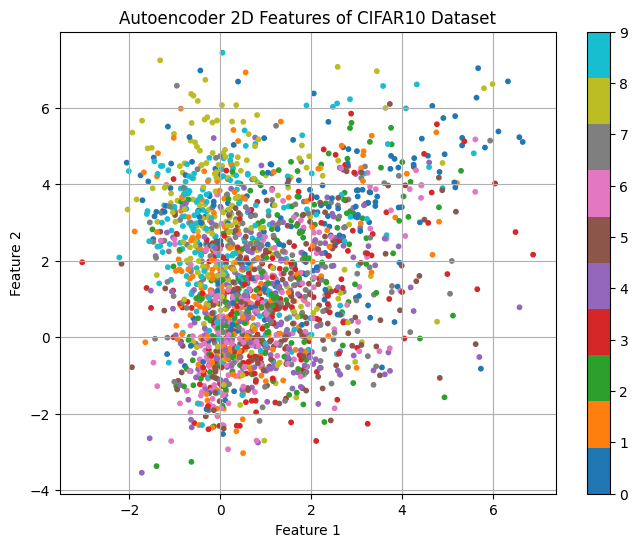

In [5]:
auto_features = encoder.predict(x_subset)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(auto_features[:, 0], auto_features[:, 1], c=y_subset, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("Autoencoder 2D Features of CIFAR10 Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Resize and preprocess
x_resized = tf.image.resize(x_subset, (224, 224))
x_resized = preprocess_input(x_resized)

# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
features_cnn = base_model.predict(x_resized)  # shape: (2000, 2048)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step


In [7]:
# PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_cnn)

# t-SNE (slower but non-linear)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features_cnn)


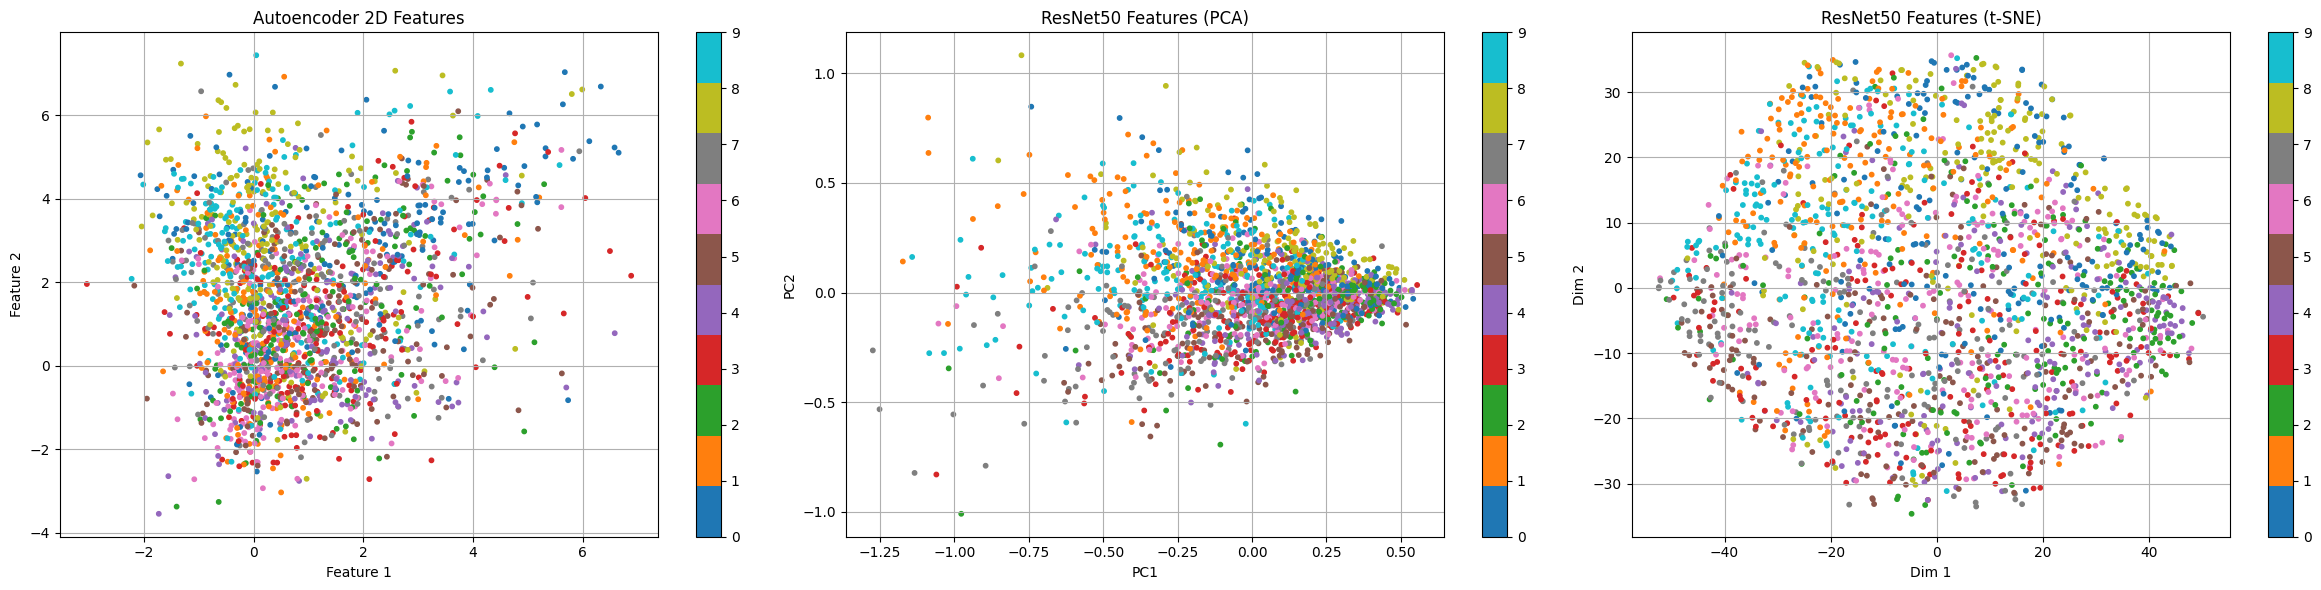

In [8]:
import matplotlib.pyplot as plt

# Create 1 row with 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 8x3 for each

# Autoencoder 2D Features
sc1 = axes[0].scatter(auto_features[:, 0], auto_features[:, 1], c=y_subset, cmap='tab10', s=10)
axes[0].set_title("Autoencoder 2D Features")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].grid(True)
fig.colorbar(sc1, ax=axes[0], ticks=range(10))

# PCA
sc2 = axes[1].scatter(pca_features[:, 0], pca_features[:, 1], c=y_subset, cmap='tab10', s=10)
axes[1].set_title("ResNet50 Features (PCA)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)
fig.colorbar(sc2, ax=axes[1], ticks=range(10))

# t-SNE
sc3 = axes[2].scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_subset, cmap='tab10', s=10)
axes[2].set_title("ResNet50 Features (t-SNE)")
axes[2].set_xlabel("Dim 1")
axes[2].set_ylabel("Dim 2")
axes[2].grid(True)
fig.colorbar(sc3, ax=axes[2], ticks=range(10))

plt.tight_layout()
plt.show()
